## Evolution of Total SEI

In this notebooks we are going to run the electron-migration SEI model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from cideMOD import (
    CSI,
    get_model_options
)

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

First we build the test plan

In [2]:
n_cycles = 5
max_step = 60
min_step = 2
time_adaptive_tol = 1e2
cycling = {
            "name": "Discharge Cycle",
            "type": "Cycle",
            "count": n_cycles,
            "steps": [
                {
                    "name": "Discharge",
                    "type": "Current", 
                    "value": -0.9, 
                    "unit": "A", 
                    "t_max": {"value": 2.5, "unit": "h"},
                    "store_delay": -1 ,
                    "max_step":max_step,
                    "min_step": min_step,
                    'time_adaptive_tol': time_adaptive_tol,
                    "events": [
                        {
                            "type": "Voltage",
                            "value": 2,  
                            "unit": "V",  
                            "atol": 1e-4, 
                            "rtol": 1e-3,
                            "goto": "Next" 
                        }
                    ]
                },
                {
                    "name": "Charge",
                    "type": "Current", 
                    "value": 0.9, 
                    "unit": "A", 
                    "t_max": {"value": 2.5, "unit": "h"},
                    "store_delay": -1,
                    "max_step":max_step,
                    "min_step": min_step,
                    'time_adaptive_tol':time_adaptive_tol,
                    "events": [
                        {
                            "type": "Voltage",
                            "value": 4.2,  
                            "unit": "V",  
                            "atol": 1e-4, 
                            "rtol": 1e-3,
                            "goto": "CV" 
                        }
                    ]
                }
            ]}

test_plan = {
    'initial_state': {
        'SOC': 1,
        'exterior_temperature': 298
    },
    'steps': [cycling]
}

Then, we activate the eletron-migration SEI model

In [3]:
model_options = get_model_options(
    model='P2D',
    SEI_model='electron_migration',
    clean_on_exit=False,
    save_path=f"results/08_total_SEI")


Saving results to /home/fenicsx/shared/cideMOD/examples/notebooks/results/results_08_total_SEI


Now we can instantiate the `CSI` object using a dataset based on `Safari 2009` and run the simulation. $^{[1]}$

In [4]:
data_path = "../../data/data_Safari_2009"
cell_data = "params_cycling_lumped_total_SEI.json"
csi = CSI(cell_data, model_options, test_plan, data_path)
status = csi.run_test_plan()

Negative electrode capacity: 1.697784
Positive electrode capacity: 2.163497
Cell capacity: 1.697784
Building mesh for P2D problem with 3 components and 90 nodes
Finished mesh construction
Initial state:
	SOC : 1
	exterior_temperature : 298
Steps:
0 -  Cycle 'Discharge Cycle' repeats 5 times:
	 0 - CC_Discharge: Apply -0.9 A during 2 hours 30 minutes until [Voltage Trigger at 2 V]
	 1 - CC_Charge: Apply 0.9 A during 2 hours 30 minutes until [Voltage Trigger at 4.2 V]
Building problem setup
- Building cell parameters - Done
- Initializing state - Done   
- Build variational formulation - Done 
-- Cycle 'Discharge Cycle', iteration number 0 --
CC_Discharge: Apply -0.9 A during 2 hours 30 minutes until [Voltage Trigger at 2 V]
Voltage is 2 V at 1h 56min 28s                   

CC_Charge: Apply 0.9 A during 2 hours 30 minutes until [Voltage Trigger at 4.2 V]
Voltage is 4.2 V at 3h 28min 27s                 

CV_CV: Apply 4.2 V during 2 hours 30 minutes until [Current Trigger at 0.085 A]
Cur

Finally, we can plot the results

In [5]:
time = np.array(csi.problem.get_global_variable('time')) / 3600 # h
voltage = csi.problem.get_global_variable('voltage')
capacity = csi.problem.get_global_variable('capacity')
delta_porous_sei = np.array(csi.problem.get_global_variable('delta_porous_sei_a')) * 1e9 # nm
delta_compact_sei = np.array(csi.problem.get_global_variable('delta_compact_sei_a')) * 1e9 # nm


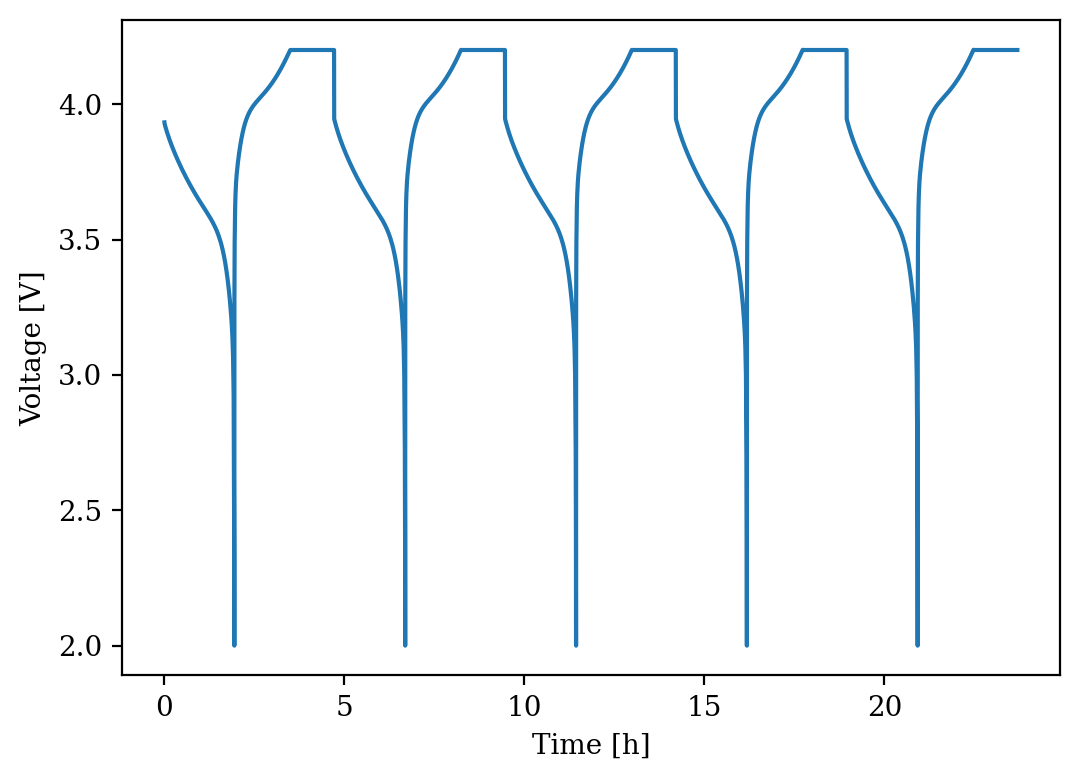

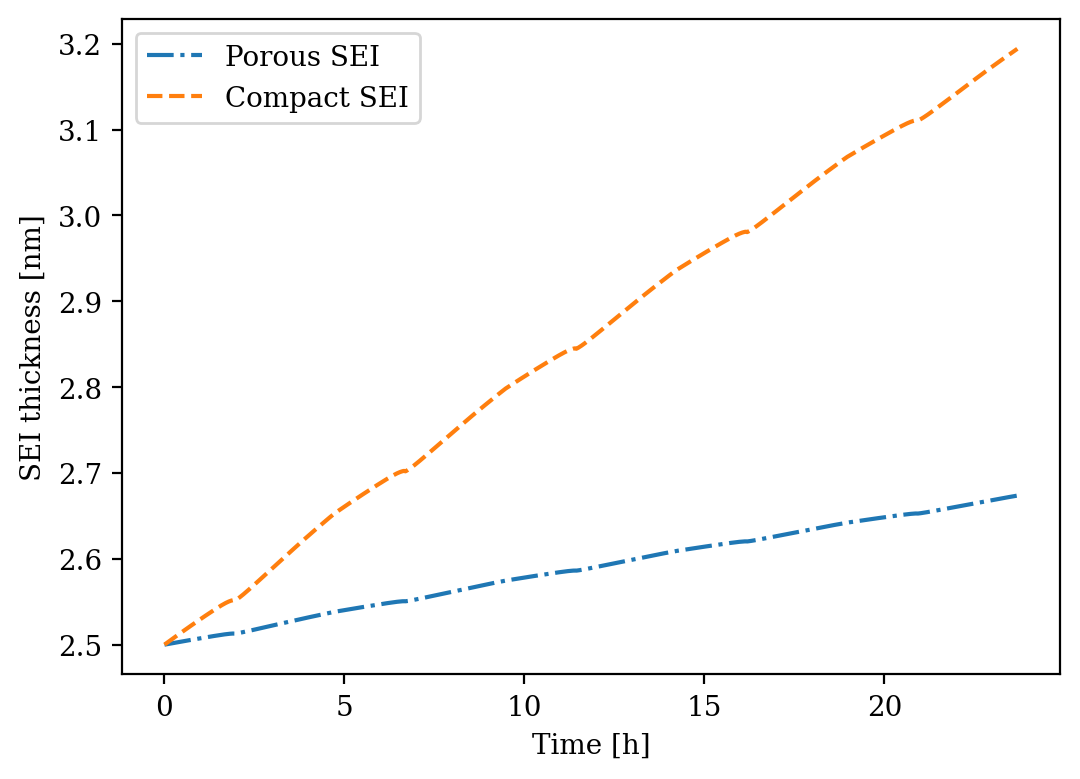

In [6]:
# plot voltage vs time
fig, ax1 = plt.subplots(1, 1, figsize=(5.5, 4), dpi=200)
ax1.plot(time, voltage, "-")
ax1.set_xlabel("Time [h]")
ax1.set_ylabel("Voltage [V]")
plt.tight_layout()
plt.show()

# plot SEI growth vs time
fig, ax1 = plt.subplots(1, 1, figsize=(5.5, 4), dpi=200)
ax1.plot(time, delta_porous_sei, "-.")
ax1.plot(time, delta_compact_sei, "--")
ax1.set_xlabel("Time [h]")
ax1.set_ylabel("SEI thickness [nm]")
ax1.legend(["Porous SEI", "Compact SEI"], loc="best")
plt.tight_layout()
plt.show()
